In [1]:
#Import the libraries
import math
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data(prob_path,stock_path):
    prob=pd.read_csv(prob_path,encoding='utf-8')    
    #取得文章時間
    stock=pd.read_csv(stock_path,encoding="utf-8")
    prob.預計影響日期 = prob.預計影響日期.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    stock.time = stock.time.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    merge = stock.merge(prob,left_on='time', right_on='預計影響日期',how='outer')
    merge = merge.rename(columns={"預計影響日期": "effect_time", "觀光類指數": "tourism","生技醫療類指數": "medical"})
    return merge
df = load_data(prob_path,stock_path)

In [3]:
#日期篩選
df[df["effect_time"].isnull()]  #最晚一天的null是0117
def filter_date(after,before,doc):    
    date = pd.to_datetime(after, format='%Y%m%d')
    date2 = pd.to_datetime(before, format='%Y%m%d')
    doc = doc[doc['time'].dt.date > date]
    doc = doc[doc['time'].dt.date < date2]
    return doc
df = filter_date('20200117','20201231',df)

In [4]:
def prepare_training_testing_data(data,column,n_features,training_partition,time_step):
    
    #準備x值
    df_sum = data.groupby('time').sum()
    #準備y值
    df_mean = data.groupby('time').mean()

    dataset = df_sum.drop(['tourism','medical'],axis=1)
    label = df_mean[column]
    
    training_data_len = math.ceil( len(dataset) *training_partition) #計算training和testing data區分處
    

    # 將pd.DataFrame 轉成 numpy array
    dataset = dataset.values
    label = label.values
    
    # 將資料標準化，先轉為(n,1)形狀
    label = label.reshape(-1,1)
    dataset = dataset.reshape(-1,1)
    
    # 將資料標準化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    scaled_label = scaler.transform(label)
    
    #將資料調回原本的形狀
    scaled_data = scaled_data.reshape(-1,n_features)
    scaled_label= scaled_label.reshape(-1,1)
    
    # 將資料切分為training & testing data 
    
    x_train,y_train,x_test,y_test = [],[],[],scaled_label[training_data_len : , : ] 
    
    train_data = scaled_data[0:training_data_len, : ]
    train_label = scaled_label[0:training_data_len, : ]

    test_data = scaled_data[training_data_len - time_step: , : ]
    test_label = scaled_label[0:training_data_len, : ]
      

    # 準備training data 
    for i in range(time_step,len(train_data)):
        x_train.append(train_data[i-time_step:i,:])
        y_train.append(train_label[i,:])
        
    # 準備testing data
    for i in range(time_step,len(test_data)):
        x_test.append(test_data[i-time_step:i,:])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    
    return x_train, y_train, x_test, y_test,scaler,training_data_len
   
x_train, y_train, x_test, y_test,scaler,training_data_len = prepare_training_testing_data(df,'tourism',18,0.8,30)    

In [5]:
def train_LSTM(x_train,y_train):
    
    #Build the LSTM network model
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, return_sequences=True,input_shape= x_train.shape[1:]))
    model.add(keras.layers.LSTM(units=64, return_sequences=False))
    model.add(keras.layers.Dense(units=32))
    model.add(keras.layers.Dense(units=1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    print(model.summary())

    #Train the model
    print('Start training model...')
    model.fit(x_train, y_train, batch_size=128, epochs=20)
    
    return model

model = train_LSTM(x_train,y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            21248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________
None
Start training model...
Epoch 1/20
15/15 [==============================] - 4s 42ms/step - loss: 0.0089
Epoch 2/20
15/15 [==============================] - 1s 41ms/step - loss: 6.1755e-04
Epoch 3/20
15/15 [==============================] - 1s 43

In [6]:
def test_LSTM(x_test,y_test):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) #標準化還原
    
    rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
    
    return predictions, rmse

predictions, rmse = test_LSTM(x_test,y_test)
print(rmse)

89.08652876078926


## 畫出類股線圖

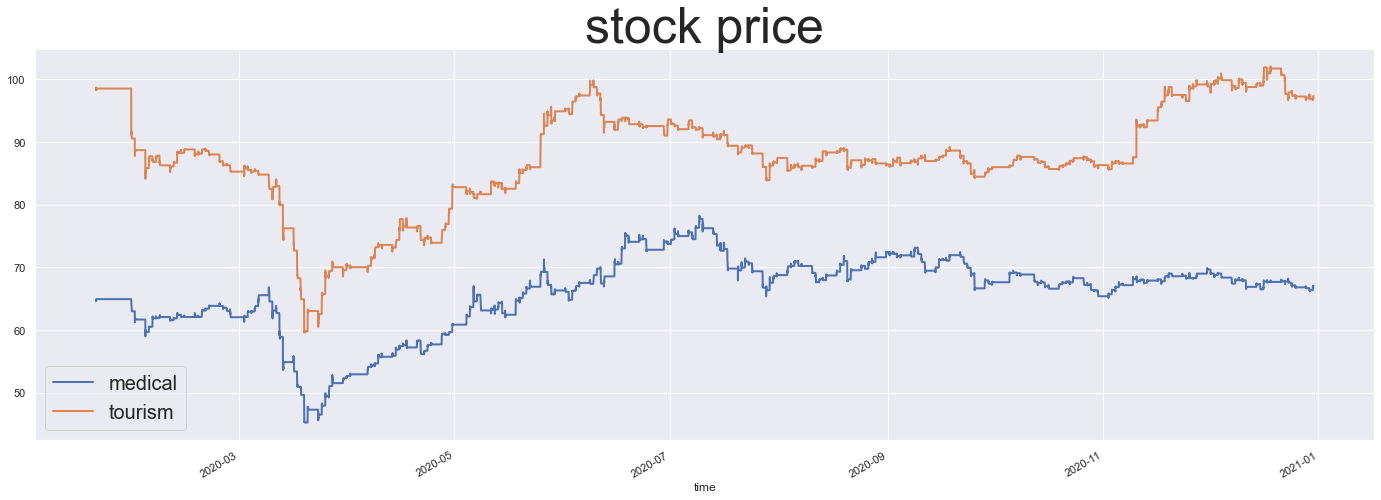

In [7]:
#將時間設成index
def plot_stock_price(stock_path):
    stock=pd.read_csv(stock_path,encoding="utf-8")
    stock.time = stock.time.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    stock = filter_date('20200117','20201231',stock)
    stock = stock.set_index('time',drop=True)
    stock.sort_index(inplace=True)
    stock = stock.rename(columns={"觀光類指數": "tourism","生技醫療類指數": "medical"})    
    sns.set(rc={'figure.figsize':(24, 8)})
    plt.title('stock price',size=50)
    stock['medical'].plot(linewidth=2,label='medical')
    stock['tourism'].plot(linewidth=2,label='tourism')
    plt.legend(loc='best',fontsize=20)
    
    return stock
    
stock = plot_stock_price(r'data/stock_data_every_30mins.csv')

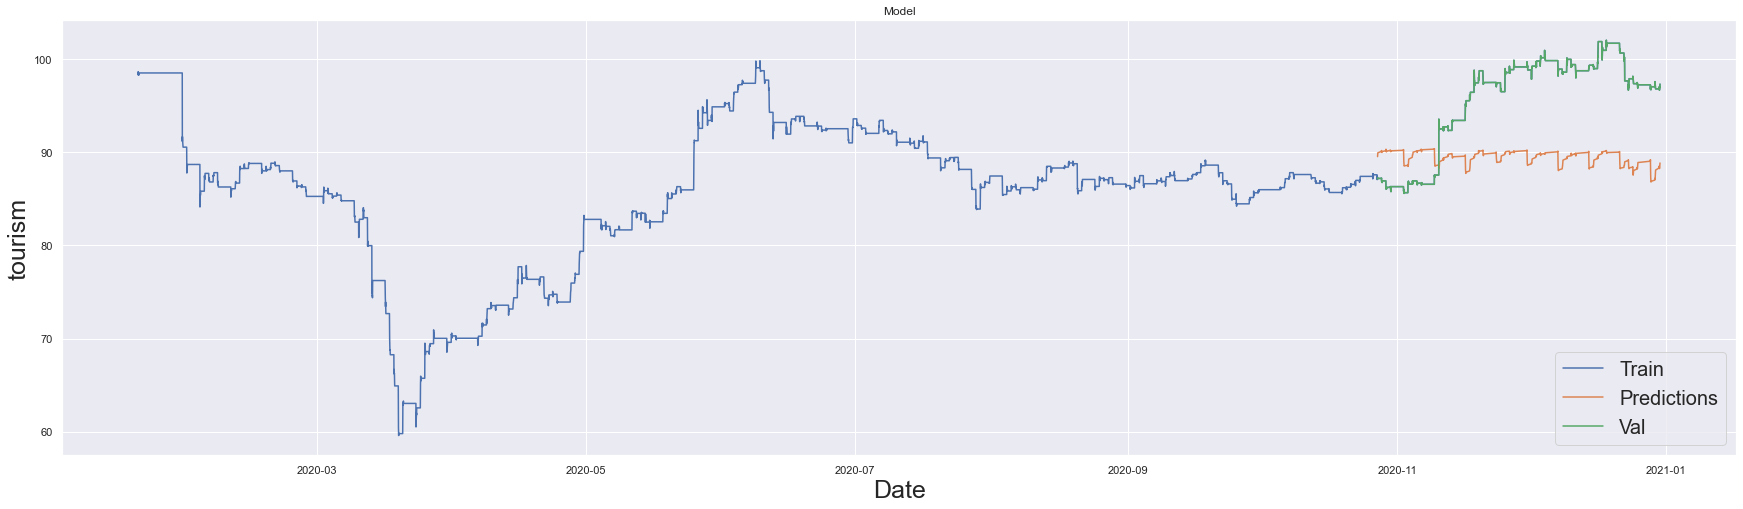

In [8]:
def prepare_plot_data(predictions,data,column,training_data_len):
    
    train = data[:training_data_len] 
    valid = data[training_data_len:]
    predictions = pd.DataFrame(data=predictions, columns=["prediction"])
    plot_data = pd.concat([predictions.set_index(valid.index),valid],axis=1)
    plot_data["prediction"].apply(lambda x: round(x,2))
    
    plt.figure(figsize=(30,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=25)
    plt.ylabel(column, fontsize=25)
    plt.plot(data[column])
    plt.plot(plot_data[['prediction','tourism']])
    plt.legend(['Train','Predictions', 'Val'], loc='lower right',fontsize=20)

prepare_plot_data(predictions,stock,'tourism',training_data_len)